In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

C:\Users\jeremy\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [4]:
EMBEDDING_FILE = 'data/GoogleNews-vectors-negative300.bin.gz'

In [5]:
stops = set(stopwords.words('english'))

In [6]:
# Load training and test set
train_df = pd.read_csv('data/train.csv', names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])
test_df = pd.read_csv('data/test.csv', names=['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'])

In [7]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,199954,384085,What are the some of the best novels?,What are some of the greatest novels of all ti...,0
1,1,128681,237407,What are the pictures that made you look twice?,What are some amazing pictures one has to see ...,0
2,2,170846,240621,Have the ellectoral college members ever voted...,When has the electoral college voted against t...,1
3,3,55110,177468,Did Ravana really have 10 heads?,Why did Ravana have 10 heads?,1
4,4,425513,400256,What's a book that you feel helped you to impr...,What books or magazines should I read to impro...,0


In [6]:
train_df.shape

(80100, 6)

In [7]:
test_df.shape

(20179, 6)

In [8]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

# Prepare embedding
vocabulary = dict()
inverse_vocabulary = ['<unk>']  # '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

In [9]:
questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():

        # Iterate through the text of both questions of the row
        for question in questions_cols:

            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

C:\Users\jeremy\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [10]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

training_size = len(train_df)

X = train_df[questions_cols]
Y = train_df['is_duplicate']

In [11]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.3)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}


# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
    
# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [12]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

#malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
malstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

C:\Users\jeremy\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\jeremy\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 56070 samples, validate on 24030 samples
Epoch 1/25
56070/56070 [==============================] - 73s 1ms/step - loss: 0.6644 - acc: 0.6690 - val_loss: 0.5526 - val_acc: 0.7253
Epoch 2/25
56070/56070 [==============================] - 72s 1ms/step - loss: 0.5277 - acc: 0.7465 - val_loss: 0.5175 - val_acc: 0.7591
Epoch 3/25
56070/56070 [==============================] - 72s 1ms/step - loss: 0.4940 - acc: 0.7692 - val_loss: 0.5023 - val_acc: 0.7583
Epoch 4/25
56070/56070 [==============================] - 73s 1ms/step - loss: 0.4734 - acc: 0.7859 - val_loss: 0.4809 - val_acc: 0.7821
Epoch 5/25
56070/56070 [==============================] - 72s 1ms/step - loss: 0.4570 - acc: 0.7953 - val_loss: 0.4690 - val_acc: 0.7906
Epoch 6/25
56070/56070 [==============================] - 72s 1ms/step - loss: 0.4420 - acc: 0.8048 - val_loss: 0.4598 - val_acc: 0.7980
Epoch 7/25
56070/56070 [==============================] - 72s 1ms/step - loss: 0.4305 - acc: 0.8120 - val_loss: 0.4510 - val_acc

In [13]:
predictions = malstm.predict([X_test['left'], X_test['right']])

In [14]:
with open("submission_file_malstm_1.csv", 'w') as f:
    f.write("Id,Score\n")
    for i in range(len(predictions)):
        f.write(str(i)
                +','
                +str(predictions[i][0])+'\n')

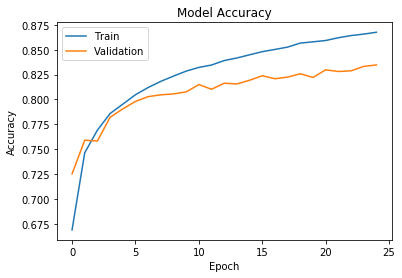

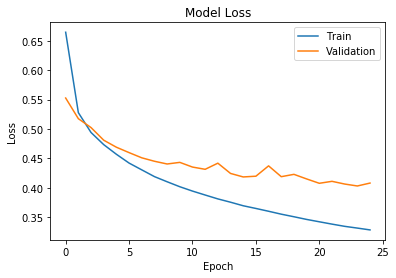

In [28]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()